In [1]:
!pip install --quiet -r https://raw.githubusercontent.com/JoaquinLCalvo/Explained-CNN-SSL/refs/heads/explainability/requirements.txt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [18]:
import os
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as FT
import torch.optim as optim
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import STL10
from tqdm.notebook import tqdm
from captum.attr import IntegratedGradients

sns.set()

In [19]:
## Data Preparation

# Path configurations
DATASET_PATH = "data/"
NUM_WORKERS = os.cpu_count()

# Data augmentations for SimCLR
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasets for contrastive learning
unlabeled_data = STL10(
    root=DATASET_PATH,
    split="unlabeled",
    download=True,
    transform=contrast_transforms
)
train_data_contrast = STL10(
    root=DATASET_PATH,
    split="train",
    download=True,
    transform=contrast_transforms
)

# Dataset for the MLP
test_data = STL10(
    root=DATASET_PATH,
    split="test",
    download=True,
    transform=transforms.Compose([
        transforms.Resize(size=96),
        transforms.ToTensor()])
)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [20]:
## SimCLR model definition

class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim=128, num_classes=10, lr=1e-3, temperature=0.07, weight_decay=1e-4, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()

        # INTERNAL NOTES
        # 1. In the future, try with other backbones (could be Resnet50, could be some EfficientNet)
        # 2. Since SimCLR learns representations directly from the data, I'm not using the pre-trained weights by now
        # to avoid the bias learned from ImageNet-like datasets. However, this should also be tested.
        # Tip: for larger datasets, pretrained=False should work better (because of what I've just exposed)
        # while for small datasets, the pretrained weights might provide a performance boost
        # Define ResNet backbone
        self.convnet = torchvision.models.resnet18(weights=None)
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)
        )

        self.classifier = nn.Linear(hidden_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50)
        return [optimizer], [scheduler]

    def forward(self, batch, classify=False):
        if classify:
            imgs = batch
            feats = self.convnet(imgs)
            return self.classifier(feats)
        else:
            imgs = batch[0]
            feats = self.convnet(imgs)
            cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
            self_mask = torch.eye(cos_sim.shape[0], device=cos_sim.device, dtype=torch.bool)
            cos_sim.masked_fill_(self_mask, -9e15)
            pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
            cos_sim = cos_sim / self.hparams.temperature
            nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
            return nll.mean()

    def training_step(self, batch, batch_idx):
        loss = self.forward(batch)
        self.log("train_loss", loss)
        return loss


In [39]:
## Train SimCLR Model

def train_simclr(batch_size=256, max_epochs=100, **kwargs):
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="gpu",
        devices=1,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, monitor="train_loss", mode="min"),
            LearningRateMonitor(logging_interval="epoch"),
        ]
    )
    train_loader = torch.utils.data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
    model = SimCLR(num_classes=10, max_epochs=max_epochs, **kwargs)
    trainer.fit(model, train_loader)
    return model

# Train the SimCLR model
simclr_model = train_simclr(hidden_dim=128, lr=1e-3, temperature=0.07, weight_decay=1e-4, max_epochs=10)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type   | Params | Mode 
----------------------------------------------
0 | convnet    | ResNet | 11.5 M | train
1 | classifier | Linear | 1.3 K  | train
----------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.024    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [42]:
## Save the model
# Path to save the model on Colab
simclr_model_save_path = "simclr_model.pth"

# Save the model's state_dict
torch.save(simclr_model.state_dict(), simclr_model_save_path)
print(f"Model saved to {simclr_model_save_path}")

# Download the model to your local machine
from google.colab import files
files.download(simclr_model_save_path)

Model saved to simclr_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
## Define MLP Classifier

class MLPClassifier(pl.LightningModule):
    def __init__(self, num_classes=10, hidden_dim=256, lr=1e-3, weight_decay=1e-4, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()

        # Define the MLP architecture
        self.model = nn.Sequential(
            nn.Conv2d(3, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(hidden_dim, num_classes)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50)
        return [optimizer], [scheduler]

    def forward(self, batch, mode="train", classify=True):
        if classify:
            feats = batch
            return self.model(feats)
        else:
            feats, labels = batch
            preds = self.model(feats)
            loss = F.cross_entropy(preds, labels)
            acc = (preds.argmax(dim=-1) == labels).float().mean()

            # Log loss and accuracy
            self.log(f"{mode}_loss", loss, prog_bar=True)
            self.log(f"{mode}_acc", acc, prog_bar=True)
            return loss

    def training_step(self, batch, batch_idx):
        return self.forward(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self.forward(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self.forward(batch, mode="test")

In [ ]:
## Train the MLP Classifier

def train_mlp(batch_size, train_feats_data, test_feats_data, max_epochs=100, **kwargs):
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="gpu",
        devices=1,
        callbacks=[
            pl.callbacks.ModelCheckpoint(save_weights_only=True, monitor="val_acc", mode="max"),
            pl.callbacks.LearningRateMonitor("epoch"),
        ],
    )

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        train_feats_data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4
    )
    test_loader = torch.utils.data.DataLoader(
        test_feats_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4
    )

    # Train the MLP
    model = MLPClassifier(num_classes=10, max_epochs=max_epochs, **kwargs)
    trainer.fit(model, train_loader, test_loader)

    # Test the model
    test_result = trainer.test(model, test_loader, verbose=False)
    print(f"Test accuracy: {test_result[0]['test_acc'] * 100:.2f}%")

    return model

mlp_model = train_mlp(batch_size=256, train_feats_data=train_data_contrast, test_feats_data=test_data, max_epochs=10)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 9.7 K  | train
-------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Test accuracy: 11.84%


In [43]:
## Save the model
# Path to save the model on Colab
mlp_model_save_path = "mlp_model.pth"

# Save the model's state_dict
torch.save(mlp_model.state_dict(), mlp_model_save_path)
print(f"Model saved to {mlp_model_save_path}")

# Download the model to your local machine
from google.colab import files
files.download(mlp_model_save_path)

Model saved to mlp_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
examples_folder = "./examples"
class_names = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]

def show(attributions, model_name="clr", save_fig=False):
    if not isinstance(attributions, list):
        attributions = [attributions]
    print("Preparing image with attributions")
    fig, ax = plt.subplots(len(attributions), 2, figsize=(10, 5 * len(attributions)))
    for idx, ex in enumerate(attributions):
        img = ex['img']
        label = ex['label']
        prediction = ex['prediction']
        attr = ex['attr']
        
        img = img.detach()
        img = FT.to_pil_image(img)
        
        ax[idx, 0].imshow(np.asarray(img))
        ax[idx, 0].set_title(f'Original Image is class {class_names[label]}')
        
        ax[idx, 1].imshow(attr)
        ax[idx, 1].set_title(f'Attributions and prediction: {class_names[prediction]}')
    plt.tight_layout()
    if save_fig:
        plt.savefig(f'{examples_folder}/{model_name}.png')
    plt.show()

In [23]:
def run_explainability(model, examples: list, model_name="clr"):

    def forward_fn(inputs):
        if inputs.dim() == 3:
            inputs = inputs.unsqueeze(0)
        return model(inputs, classify=True)
    ig = IntegratedGradients(forward_fn)

    results = []
    for ex in examples:
        input_tensor = ex['img']
        input_tensor = input_tensor.unsqueeze(0)

        with torch.no_grad():
            logits = model(input_tensor, classify=True)
            target_class = logits.argmax(dim=-1).item()

        attributions, delta = ig.attribute(
            inputs=input_tensor, target=target_class, return_convergence_delta=True
        )
        attributions_np = attributions[0].cpu().detach().numpy()
        attributions_np = (attributions_np - attributions_np.min()) / (attributions_np.max() - attributions_np.min())
        results.append({
            'img': ex['img'],
            'label': ex['label'],
            'prediction': target_class,
            'attr': attributions_np.transpose(1, 2, 0)
        })

    show(attributions=results, model_name=model_name)


In [24]:
# Reinitialize the model
simclr_model = SimCLR()

# Load the saved state_dict
simclr_model.load_state_dict(torch.load("saved_models/simclr_model.pth", weights_only=True))
simclr_model.eval()  # Set the model to evaluation mode

SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [25]:
# Reinitialize the model
mlp_model = MLPClassifier()

# Load the saved state_dict
mlp_model.load_state_dict(torch.load("saved_models/mlp_model.pth", weights_only=True))
mlp_model.eval()  # Set the model to evaluation mode

MLPClassifier(
  (model): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AdaptiveAvgPool2d(output_size=(1, 1))
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [26]:
# Getting some example images from the dataset
EXAMPLES_COUNT = 5
examples = []
for i in range(EXAMPLES_COUNT):
    image, label = test_data[i]
    examples.append({
        'img': image,
        'label': label
    })
print(f"Got the first {len(examples)} images transformed")

Got the first 5 images transformed


Preparing image with attributions


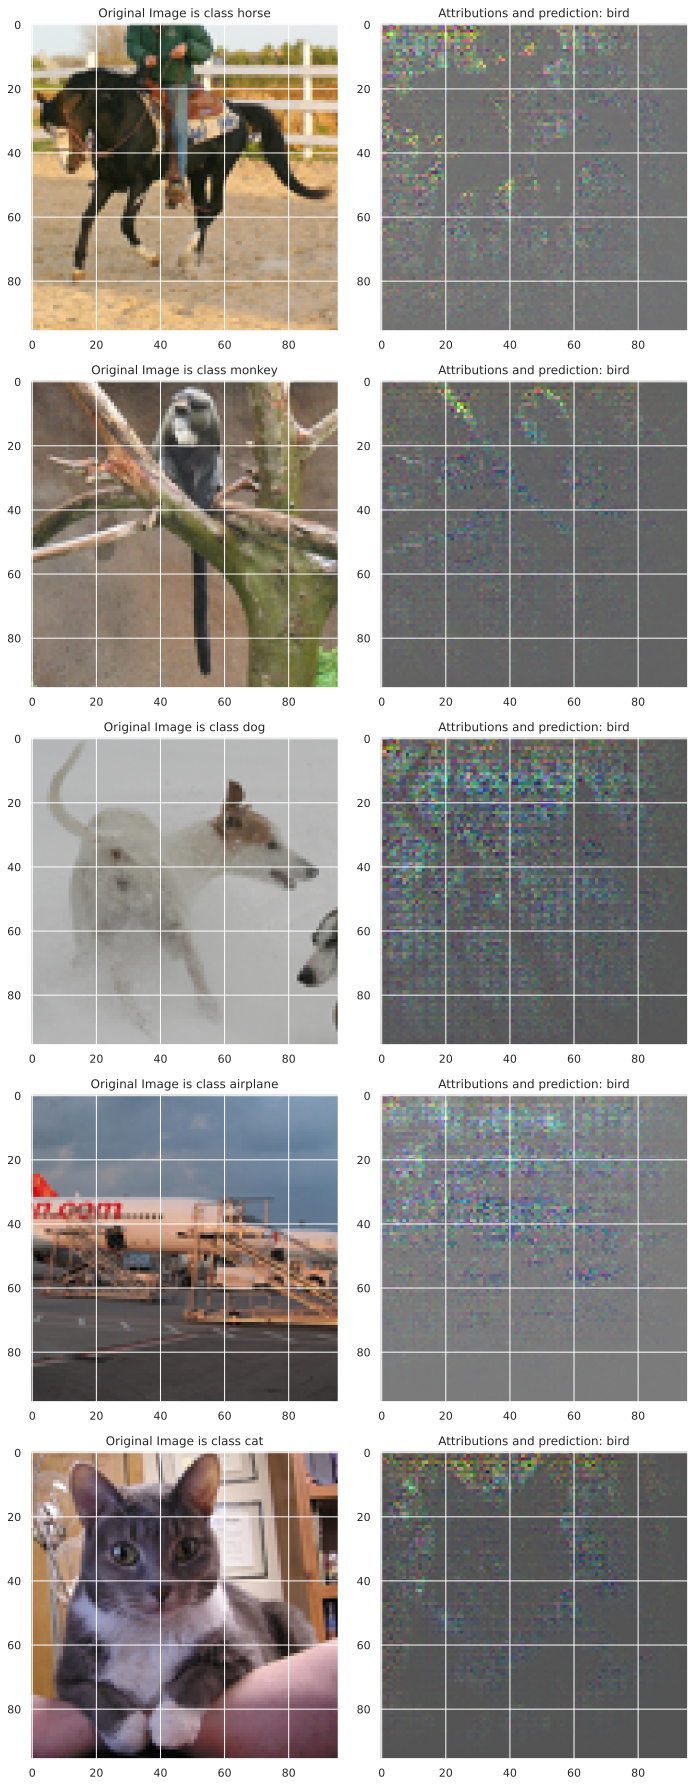

In [27]:
run_explainability(model=simclr_model, examples=examples, model_name="clr")

Preparing image with attributions


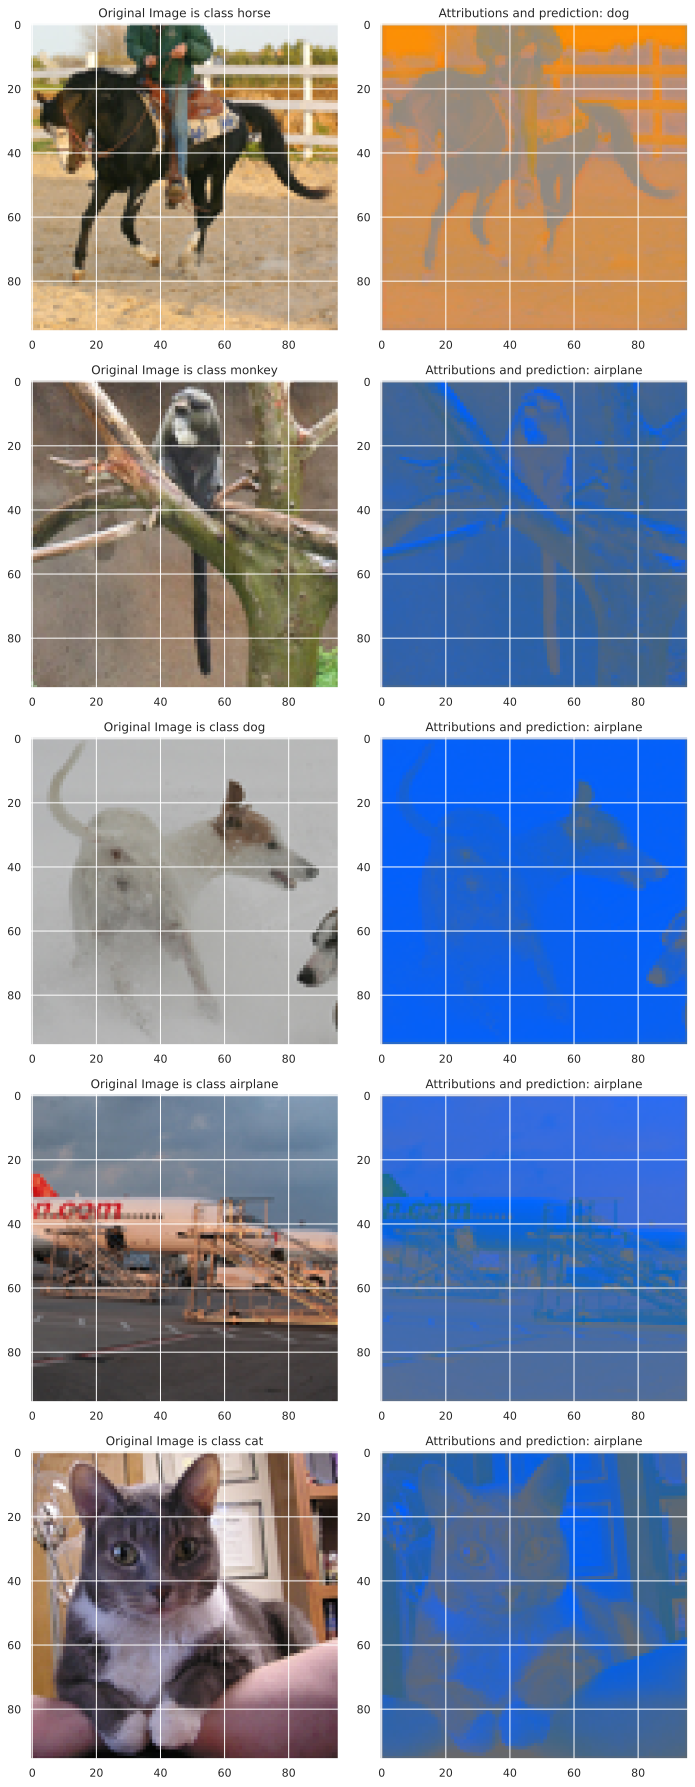

In [28]:
run_explainability(model=mlp_model, examples=examples, model_name="cnn")